In [1]:
from lifelines import KaplanMeierFitter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from pathlib import Path

In [2]:
rcParams["svg.fonttype"] = "none"

Loading the tabular data (.json files):

In [3]:
# TO DO: Specify path to structured data
data_dir = Path("../Hancock_Dataset/StructuredData")
data_dir = Path.cwd() / '..' / '..' / 'Hancock_Dataset' / 'StructuredData'

In [4]:
# Load survival data and additional data
clinical = pd.read_json(data_dir/"clinical_data.json", dtype={"patient_id": str})
patho = pd.read_json(data_dir/"pathological_data.json", dtype={"patient_id": str})
df = clinical[["patient_id", "survival_status", "days_to_last_information"]].copy()

In [5]:
# Convert number of days to number of months
avg_days_per_month = 365.25 / 12
df["followup_months"] = np.round(df["days_to_last_information"] / avg_days_per_month)

# Define event: 1 = deceased, 0 = censored
df.survival_status = df.survival_status == "deceased"
df.survival_status = df.survival_status.astype(int)

## 5-year survival rate

In [6]:
def calculate_survival_rate(dataframe, years):
    months = 12 * years
    num_patients = len(dataframe)
    
    num_died_within_x_years = len(dataframe[(dataframe.followup_months < months) & (dataframe.survival_status == 1)])
    survival_rate = (num_patients - num_died_within_x_years) / num_patients * 100
    
    print(f"{years}-year survival rate = {survival_rate:.1f} %")

In [7]:
calculate_survival_rate(df, 5)

5-year survival rate = 77.3 %


In [8]:
calculate_survival_rate(df, 2)

2-year survival rate = 86.8 %


## Overall survival (Kaplan-Meier estimate)

In [9]:
# Kaplan-Meier estimator for overall survival
kmf = KaplanMeierFitter()
kmf.fit(durations=df.followup_months, event_observed=df.survival_status)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 763 total observations, 550 right-censored observations>

In [10]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,2,1,1,763,763
1.0,13,2,11,0,761
2.0,16,6,10,0,748
3.0,12,8,4,0,732
4.0,12,6,6,0,720
...,...,...,...,...,...
148.0,2,1,1,0,6
153.0,1,0,1,0,4
158.0,1,0,1,0,3


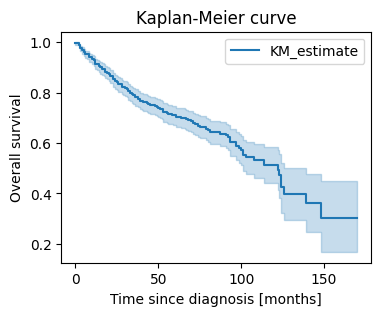

In [11]:
plt.figure(figsize=(4, 3))
kmf.plot(ci_show=True, show_censors=False) # ci = confidence interval
plt.ylabel("Overall survival")
plt.xlabel("Time since diagnosis [months]")
plt.title("Kaplan-Meier curve")
plt.show()

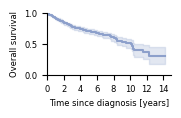

In [12]:
# Small plot for Figure 1
rcParams.update({"font.size": 6})

plt.figure(figsize=(1.6,0.8))
kmf.plot(ci_show=True, show_censors=False, color=sns.color_palette("Set2")[2], ci_no_lines=False) # ci = confidence interval
plt.xticks([x*12 for x in [0,2,4,6,8,10,12,14]])
plt.xticks(ticks=plt.xticks()[0], labels=[f"{int(x/12)}" for x in plt.xticks()[0]])
plt.ylim([0, 1])
plt.xlim([0, 15*12])
plt.ylabel("Overall survival")
plt.xlabel("Time since diagnosis [years]")
sns.despine()
plt.legend("", frameon=False)
# plt.savefig("kaplanmeier_os.svg", bbox_inches="tight")
plt.show()

rcParams.update({"font.size": 10})

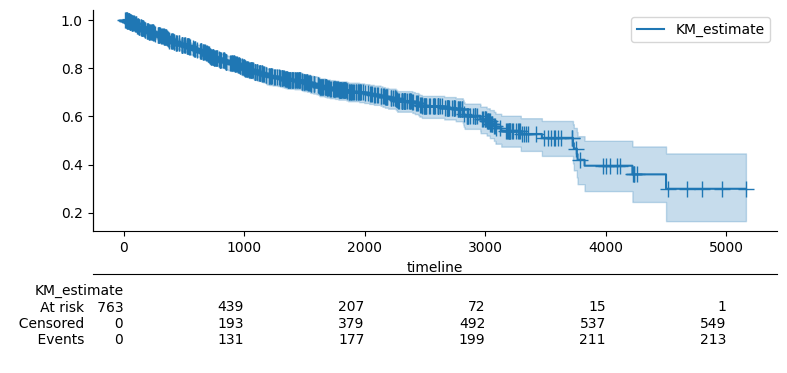

In [13]:
# Show number of days and additional information: at-risk, censored, events
kmf_days = KaplanMeierFitter()
kmf_days.fit(durations=df.days_to_last_information, event_observed=df.survival_status)

plt.figure(figsize=(8, 4))
kmf_days.plot(ci_show=True, show_censors=True, at_risk_counts=True)
sns.despine()
# plt.savefig("kaplanmeier_details.svg", bbox_inches="tight")
plt.show()

## Overall survival for grouped cases

In [14]:
df = df.merge(patho, on="patient_id")

In [15]:
df

,patient_id,survival_status,days_to_last_information,followup_months,primary_tumor_site,pT_stage,pN_stage,grading,hpv_association_p16,number_of_positive_lymph_nodes,...,perinodal_invasion,lymphovascular_invasion_L,vascular_invasion_V,perineural_invasion_Pn,resection_status,resection_status_carcinoma_in_situ,carcinoma_in_situ,closest_resection_margin_in_cm,histologic_type,infiltration_depth_in_mm
0,001,0,2258,74.0,Hypopharynx,pT4a,pN2b,G3,not_tested,3.0,...,yes,yes,no,no,R0,CIS Absent,no,<0.1,SCC_Basaloid,19.0
1,002,0,1753,58.0,Larynx,pT2,pN2c,G3,not_tested,3.0,...,yes,yes,no,no,R0,CIS Absent,no,None,SCC_Conventional-Keratinizing,9.0
2,003,0,851,28.0,Oropharynx,pT1,pN1,hpv_association_p16,positive,1.0,...,no,no,no,no,R0,CIS Absent,no,0.5,SCC_Basaloid,7.0
3,004,0,2996,98.0,Oral_Cavity,pT2,pN0,G2,not_tested,0.0,...,None,no,no,no,R0,Ris0,yes,0.3,SCC_Conventional-Keratinizing,8.0
4,005,1,2819,93.0,Oropharynx,pT1,NX,hpv_association_p16,positive,NaN,...,None,no,no,no,R0,Ris0,yes,0.5,SCC_Conventional-Keratinizing,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,759,1,1000,33.0,Larynx,pT2,pN2c,G2,not_tested,9.0,...,yes,yes,no,yes,R0,CIS Absent,no,0.5,SCC_Conventional-Keratinizing,15.0
759,760,1,484,16.0,Oropharynx,pT3,pN0,G3,negative,0.0,...,None,no,no,no,R0,CIS Absent,no,None,SCC_Conventional-Keratinizing,10.0
760,761,1,1082,36.0,Hypopharynx,pT2,pN3b,G3,not_tested,5.0,...,yes,yes,yes,yes,R0,CIS Absent,no,0.5,SCC_Basaloid,8.0
761,762,0,1644,54.0,Oropharynx,pT2,pN1,hpv_association_p16,positive,1.0,...,no,no,no,no,R0,CIS Absent,no,<0.1,SCC_Basaloid,4.0


In [16]:
def plot_grouped_os(dataframe, feature, filename=None):
    plt.figure(figsize=(4, 3))
    ax = plt.subplot(111)

    for i, f in enumerate(sorted(dataframe[feature].unique())):
        temp = dataframe[dataframe[feature] == f]
        color = sns.color_palette("Set2")[i]
        kmf = KaplanMeierFitter()
        kmf.fit(durations=temp.followup_months, event_observed=temp.survival_status, label=f)
        kmf.plot(ax=ax, ci_show=False, color=color)

    plt.xlim([0, 15*12])
    plt.ylim([0, 1.01])
    sns.despine()
    plt.ylabel("Overall survival probability")
    plt.xlabel("Time since diagnosis [months]")
    plt.legend(loc="lower left", fontsize=9, frameon=False)
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

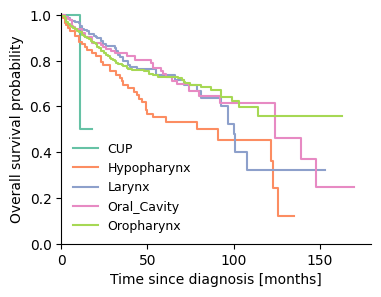

In [17]:
plot_grouped_os(df, "primary_tumor_site")

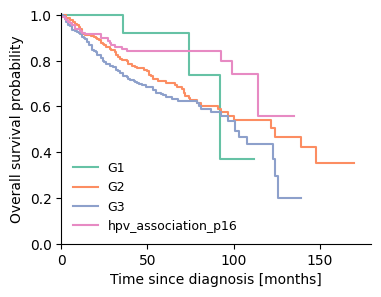

In [18]:
plot_grouped_os(df, "grading")

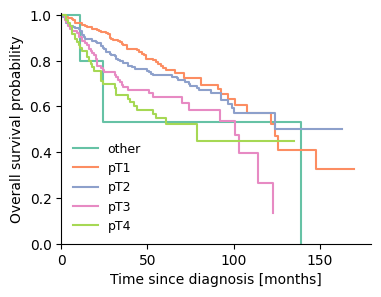

In [19]:
# Summarize pathological T stages
df["pT"] = df.pT_stage.replace({"pT4a": "pT4", "pT4b": "pT4", "pT1a": "pT1", "pT1b": "pT1", "pTis": "other", "TX": "other"})
plot_grouped_os(df, "pT")

hpv_association_p16
negative      189
positive      141
not_tested      1
Name: count, dtype: int64


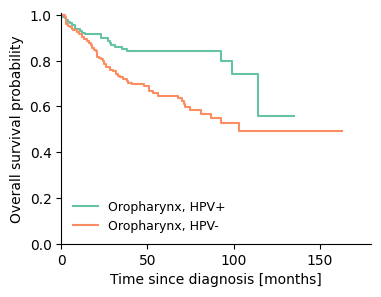

In [20]:
# Only consider oropharyngeal carcinomas and compare HPV-positive and HPV-negative cases
oro = df[df.primary_tumor_site == "Oropharynx"]
print(oro.hpv_association_p16.value_counts())
oro = oro[oro.hpv_association_p16 != "not_tested"] # discard not tested case
oro.hpv_association_p16 = oro.hpv_association_p16.replace({"positive": "Oropharynx, HPV+", "negative": "Oropharynx, HPV-"})

plot_grouped_os(oro, "hpv_association_p16")